In [172]:
from processor.processor import Processor as processor
from database.adatabase import ADatabase
from xgboost import XGBRegressor
from statistics import mean
import math
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm
from dotenv import load_dotenv
from asset.stock import Stock
from asset.bond import Bond
from asset.option import Option
import warnings
import pytz
import copy
warnings.simplefilter(action="ignore")

In [173]:
factors =  [
            "assets"
            ,"liabilities"
            ,"netincomeloss"
            ,"adjclose" 
            ,"rf"
            ,"spy"
           ]
required = ["year","quarter","ticker"]
required.extend(factors)
market = ADatabase("market")
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")

In [174]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",attrs={"id":"constituents"})[0].rename(columns={"Symbol":"ticker"})

In [175]:
fred.connect()
market_yield = fred.retrieve("market_yield")
market_yield = market_yield.rename(columns={"value":"rf"})
market_yield["rf"] = market_yield["rf"].replace(".",np.nan)
market_yield.dropna(inplace=True)
market_yield["rf"] = [float(x)/100 for x in market_yield["rf"]]
market_yield["date"] = market_yield["date"].shift(-5)
market_yield = processor.column_date_processing(market_yield)
spy = fred.retrieve("sp500")
spy = spy.rename(columns={"value":"spy"})
spy["spy"] = spy["spy"].replace(".",np.nan)
spy.dropna(inplace=True)
spy["spy"] = [float(x) for x in spy["spy"]]
spy = processor.column_date_processing(spy)
fred.disconnect()

In [176]:
data = []
sec.connect()
market.connect()
for ticker in tqdm(sp500["ticker"]):
    try:
        cik = int(sp500[sp500["ticker"]==ticker]["CIK"].item())
        filing = sec.query("filings",{"cik":cik}).drop("date",axis=1)
        prices = processor.column_date_processing(market.query("prices",{"ticker":ticker})).drop("date",axis=1)
        filing["ticker"] = ticker
        filing["year"] = filing["year"] + 1
        ticker_data = prices.merge(filing,on=["year","quarter","ticker"],how="left")
        ticker_data = ticker_data.merge(market_yield[["year","quarter","rf"]].groupby(["year","quarter"]).mean().reset_index(),on=["year","quarter"],how="left")
        ticker_data = ticker_data.merge(spy[["year","quarter","spy"]].groupby(["year","quarter"]).mean().reset_index(),on=["year","quarter"],how="left")
        ticker_data = ticker_data.groupby(["year","quarter","ticker"]).mean().reset_index()
        ticker_data.sort_values(["year","quarter"],inplace=True)
        ticker_data["y"] = ticker_data["adjclose"].shift(-1)
        data.append(ticker_data.bfill().ffill().dropna())
    except Exception as e:
        print(ticker,str(e))
        continue
sec.disconnect()
market.disconnect()

 13%|██████████████████▉                                                                                                                                  | 64/503 [00:07<00:42, 10.26it/s]

BRK.B 'date'


 16%|███████████████████████▉                                                                                                                             | 81/503 [00:09<00:38, 11.04it/s]

BF.B 'date'


 27%|████████████████████████████████████████▎                                                                                                           | 137/503 [00:15<00:35, 10.24it/s]

CRWD 'date'


 43%|███████████████████████████████████████████████████████████████▎                                                                                    | 215/503 [00:23<00:22, 12.54it/s]

GEV "['date'] not found in axis"


 45%|██████████████████████████████████████████████████████████████████▏                                                                                 | 225/503 [00:24<00:23, 11.80it/s]

GDDY 'date'


 56%|██████████████████████████████████████████████████████████████████████████████████▉                                                                 | 282/503 [00:30<00:18, 11.83it/s]

KKR 'date'


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 422/503 [00:46<00:07, 11.24it/s]

SOLV "['date'] not found in axis"


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:56<00:00,  8.91it/s]

ZBH 'date'
ZTS 'date'


In [177]:
training_data = pd.concat(data).sort_values(["year","quarter"]).merge(sp500[["ticker","GICS Sector"]],on="ticker")

In [178]:
model = XGBRegressor(fit_intercept=True)
model_data = training_data[(training_data["year"]<=2023) & (training_data["year"]>=2016)].dropna()
sim = training_data[(training_data["year"]>=2022)]
model.fit(model_data[factors],model_data["y"])
sim["prediction"] = model.predict(sim[factors])

In [179]:
sim

,year,quarter,ticker,close,high,low,open,volume,adjclose,adjhigh,...,weekday,assets,liabilities,netincomeloss,cik,rf,spy,y,GICS Sector,prediction
22940,2022,1,MMM,159.032419,160.863773,157.389527,159.421032,3.566846e+06,119.112656,120.484157,...,2.032258,4.600150e+10,3.447300e+10,2.296091e+09,66740.0,0.018792,4463.855484,109.362939,Industrials,115.508621
22941,2022,1,AOS,72.774194,73.880832,71.981192,73.136452,1.146112e+06,69.497889,70.554435,...,2.032258,3.096733e+09,1.351800e+09,1.703636e+08,91142.0,0.018792,4463.855484,57.548347,Industrials,62.141327
22942,2022,1,ADBE,481.100806,490.196465,472.416590,481.864953,4.067037e+06,481.100806,490.196465,...,2.032258,2.357875e+10,1.092775e+10,1.418273e+09,796343.0,0.018792,4463.855484,406.984355,Information Technology,425.488098
22943,2022,1,AES,22.605000,22.916760,22.288237,22.582419,6.121075e+06,20.983899,21.273168,...,2.032258,3.359067e+10,1.590000e+08,1.728182e+08,874761.0,0.018792,4463.855484,20.404662,Utilities,21.290043
22944,2022,1,AFL,62.607581,63.199982,61.898145,62.518710,3.311666e+06,59.112907,59.672198,...,2.032258,1.589270e+11,1.276680e+11,3.667333e+09,4977.0,0.018792,4463.855484,56.083719,Financials,55.295692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26536,2024,2,WTW,257.682759,259.526374,255.736584,257.657414,4.507254e+05,257.682759,259.526374,...,2.034483,3.183750e+10,2.170300e+10,1.119083e+09,1140536.0,0.044647,5227.569828,257.682759,Financials,220.120499
26537,2024,2,WYNN,96.622414,97.773438,95.739190,96.907759,1.719473e+06,96.472444,97.621358,...,2.034483,1.356956e+10,1.519793e+10,-8.549600e+07,1174922.0,0.044647,5227.569828,96.472444,Consumer Discretionary,97.065170
26538,2024,2,XYL,135.992414,136.996636,134.645555,135.928276,1.254508e+06,135.740931,136.743238,...,2.034483,7.946000e+09,4.400000e+09,2.179167e+08,1524472.0,0.044647,5227.569828,135.740931,Industrials,129.308228
26539,2024,2,YUM,138.066379,139.083447,136.987502,138.054483,1.987651e+06,137.615610,138.629520,...,2.034483,5.797500e+09,1.462250e+10,8.087500e+08,1041061.0,0.044647,5227.569828,137.615610,Consumer Discretionary,143.370667


In [180]:
prices = []
market.connect()
for ticker in tqdm(sim["ticker"].unique()):
    try:
        price = processor.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date",inplace=True)
        price["sigma"] = price["adjclose"].pct_change(262).rolling(262).std()
        price = price.merge(spy[["date","spy"]],on="date",how="left")
        price = price.merge(market_yield[["date","rf"]],on="date",how="left")
        price = price.merge(sim[["year","quarter","ticker","GICS Sector","prediction"]],on=["year","quarter","ticker"],how="left").dropna()
        price["historical_return"] = price["adjclose"].pct_change(65)
        price["avg_hr"] = price["historical_return"].rolling(100).mean()
        price["std_hr"] = price["historical_return"].rolling(100).std()
        price["coev"] = price["adjclose"].rolling(100).std() / price["adjclose"].rolling(100).mean()
        price["z_score"] = (price["historical_return"] - price["avg_hr"]) / price["std_hr"]
        price["benchmark_historical_return"] = price["spy"].pct_change(65)
        price["covar"] = price["historical_return"].rolling(100).cov(price["benchmark_historical_return"].rolling(100).mean())
        price["var"] = price["benchmark_historical_return"].rolling(100).var()
        price["beta"] = price["covar"] / price["var"]
        price["expected_return"] = (price["prediction"] - price["adjclose"]) / price["adjclose"]
        price["type"] = ["value" if x > 0 else "growth" for x in price["historical_return"]]
        price["excess_return"] = price["rf"] + price["beta"] * (price["historical_return"] - price["rf"])
        price["absolute_return"] = price["excess_return"].abs()
        prices.append(price)
    except Exception as e:
        print(ticker,str(e))
        continue
market.disconnect()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 361/361 [00:44<00:00,  8.04it/s]


In [181]:
sim = pd.concat(prices)[["date","quarter","weekday","ticker","adjclose","GICS Sector","expected_return","excess_return","coev","absolute_return","type","rf","sigma","z_score"]]
sim = sim[(sim["date"]>datetime(2024,1,1).astimezone(pytz.utc))].dropna()

In [182]:
sim.dropna()

,date,quarter,weekday,ticker,adjclose,GICS Sector,expected_return,excess_return,coev,absolute_return,type,rf,sigma,z_score
4916,2024-01-02 00:00:00+00:00,1,1,MMM,90.701148,Industrials,-0.013504,0.026930,0.071560,0.026930,value,0.0390,0.065382,2.372784
4917,2024-01-03 00:00:00+00:00,1,2,MMM,88.878880,Industrials,0.006722,0.025376,0.072269,0.025376,value,0.0389,0.066111,2.071091
4918,2024-01-04 00:00:00+00:00,1,3,MMM,89.192211,Industrials,0.003186,0.021206,0.073010,0.021206,value,0.0379,0.066901,2.011145
4919,2024-01-05 00:00:00+00:00,1,4,MMM,89.538525,Industrials,-0.000694,0.010402,0.073767,0.010402,value,0.0384,0.067662,2.444389
4920,2024-01-08 00:00:00+00:00,1,0,MMM,89.761155,Industrials,-0.003173,0.002082,0.074596,0.002082,value,0.0388,0.068449,2.572175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5029,2024-06-13 00:00:00+00:00,2,3,ZBRA,308.910000,Information Technology,-0.124393,0.027805,0.081103,0.027805,value,0.0428,0.125067,-1.298268
5030,2024-06-14 00:00:00+00:00,2,4,ZBRA,301.370000,Information Technology,-0.102487,0.038660,0.080257,0.038660,value,0.0443,0.125559,-1.557651
5031,2024-06-17 00:00:00+00:00,2,0,ZBRA,302.400000,Information Technology,-0.105544,0.034145,0.079286,0.034145,value,0.0447,0.126067,-1.348611
5032,2024-06-18 00:00:00+00:00,2,1,ZBRA,295.250000,Information Technology,-0.083883,0.047924,0.078359,0.047924,value,0.0439,0.126161,-1.813574


In [183]:
# Initialize variables
start = sim["date"].min()
end = sim["date"].max()
date = start
number_of_stocks = 5
portfolio = {
    "date": date,
    "tax": 0,
    "fees": 0,
    "cash": 100000,
    "positions": [
        {
            "stocks": [{"ticker": "", "adjclose": 0, "quantity": 0} for _ in range(number_of_stocks)],
            "bonds": [{} for _ in range(number_of_stocks)],
            "options": [{} for _ in range(number_of_stocks)]
        }
        for _ in sp500["GICS Sector"].unique()
    ]
}
states = []
trades = []
previous_quarter = 0
annual_balance = 100000

for date in sim.sort_values("date")["date"].unique():
    today = sim[sim["date"] == date].copy()
    if today.index.size > 0:
        try:
            portfolio = copy.deepcopy(portfolio)
            quarter = today["quarter"].mean()
            day = today["weekday"].mean()
            cash = portfolio["cash"]
            portfolio["date"] = date
            positions = copy.deepcopy(portfolio["positions"])
            
            for i in range(11):
                position = positions[i]
                sector = list(sp500["GICS Sector"].unique())[i]
                stocks = copy.deepcopy(position["stocks"])
                bonds = copy.deepcopy(position["bonds"])
                options = copy.deepcopy(position["options"])
                
                for j in range(number_of_stocks):
                    stock = stocks[j]
                    option = options[j]
                    bond = bonds[j]
                    ticker = stock["ticker"]
                    if ticker != "":
                        row = today[today["ticker"] == ticker].iloc[0]
                        stock = Stock.update(row, stock)
                        position["stocks"][j] = stock
                        option = Option.update(row, option)
                        position["options"][j] = option
                        bond = Bond.update(row, bond)
                        position["bonds"][j] = bond
                positions[i] = position
            portfolio["positions"] = positions
            
            if quarter != previous_quarter:
                cash = portfolio["cash"]
                positions = copy.deepcopy(portfolio["positions"])
                
                for i in range(11):
                    position = positions[i]
                    sector = list(sp500["GICS Sector"].unique())[i]
                    stocks = copy.deepcopy(position["stocks"])
                    bonds = copy.deepcopy(position["bonds"])
                    options = copy.deepcopy(position["options"])
                    
                    for j in range(number_of_stocks):
                        stock = stocks[j]
                        option = options[j]
                        bond = bonds[j]
                        ticker = stock["ticker"]
                        if ticker != "":
                            row = today[today["ticker"] == ticker].iloc[0]
                            stock = Stock.sell(row, stock)
                            position["stocks"][j] = stock
                            trades.append(stock)
                            option = Option.sell(row, option)
                            position["options"][j] = option
                            bond = Bond.sell(row, bond)
                            position["bonds"][j] = bond
                            portfolio["cash"] += stock["pv"] + option["pv"] + bond["pv"]
                    positions[i] = position
                portfolio["positions"] = positions
                cash = portfolio["cash"]
                positions = copy.deepcopy(portfolio["positions"])
                
                for i in range(11):
                    notional = float(cash / 11 / number_of_stocks)
                    position = positions[i]
                    sector = list(sp500["GICS Sector"].unique())[i]
                    bonds = copy.deepcopy(position["bonds"])
                    options = copy.deepcopy(position["options"])
                    stocks = copy.deepcopy(position["stocks"])
                    
                    for j in range(number_of_stocks):
                        stock = stocks[j]
                        option = options[j]
                        bond = bonds[j]
                        row = today[today["GICS Sector"] == sector].sort_values("expected_return", ascending=False).iloc[j]
                        stock = Stock.buy(row, stock, notional * 0.6)
                        position["stocks"][j] = stock
                        option = Option.buy(row, option, notional * 0.0)
                        position["options"][j] = option
                        bond = Bond.buy(row, bond, notional * 0.4)
                        position["bonds"][j] = bond
                    positions[i] = position
                portfolio["positions"] = positions
                portfolio["cash"] = 0       
            states.append(copy.deepcopy(portfolio))
            previous_quarter = quarter
        except Exception as e:
            print(f"Error on date {date}: {str(e)}")
            continue

In [184]:
portfolios = []
for state in states:
    for i in range(11):
        for j in range(number_of_stocks):
            view = state["positions"][i]["stocks"][j]
            view["date"] = state["date"]
            portfolios.append(state["positions"][i]["stocks"][j])

In [185]:
industry_visualization = pd.DataFrame(portfolios).merge(sp500[["ticker","GICS Sector"]],on="ticker",how="left").dropna().merge(market_yield[["date","rf"]],on="date",how="left")
industry_visualization = industry_visualization.groupby(["date","GICS Sector"]).agg({"pv":"sum","rf":"mean"}).reset_index()

In [186]:
industry_visualization

,date,GICS Sector,pv,rf
0,2024-04-01 00:00:00+00:00,Communication Services,6121.833682,0.0422
1,2024-04-01 00:00:00+00:00,Consumer Discretionary,6121.833682,0.0422
2,2024-04-01 00:00:00+00:00,Consumer Staples,6121.833682,0.0422
3,2024-04-01 00:00:00+00:00,Energy,6121.833682,0.0422
4,2024-04-01 00:00:00+00:00,Financials,6121.833682,0.0422
...,...,...,...,...
622,2024-06-20 00:00:00+00:00,Industrials,6711.117713,0.0431
623,2024-06-20 00:00:00+00:00,Information Technology,7455.135931,0.0431
624,2024-06-20 00:00:00+00:00,Materials,6503.993768,0.0431
625,2024-06-20 00:00:00+00:00,Real Estate,6643.833958,0.0431


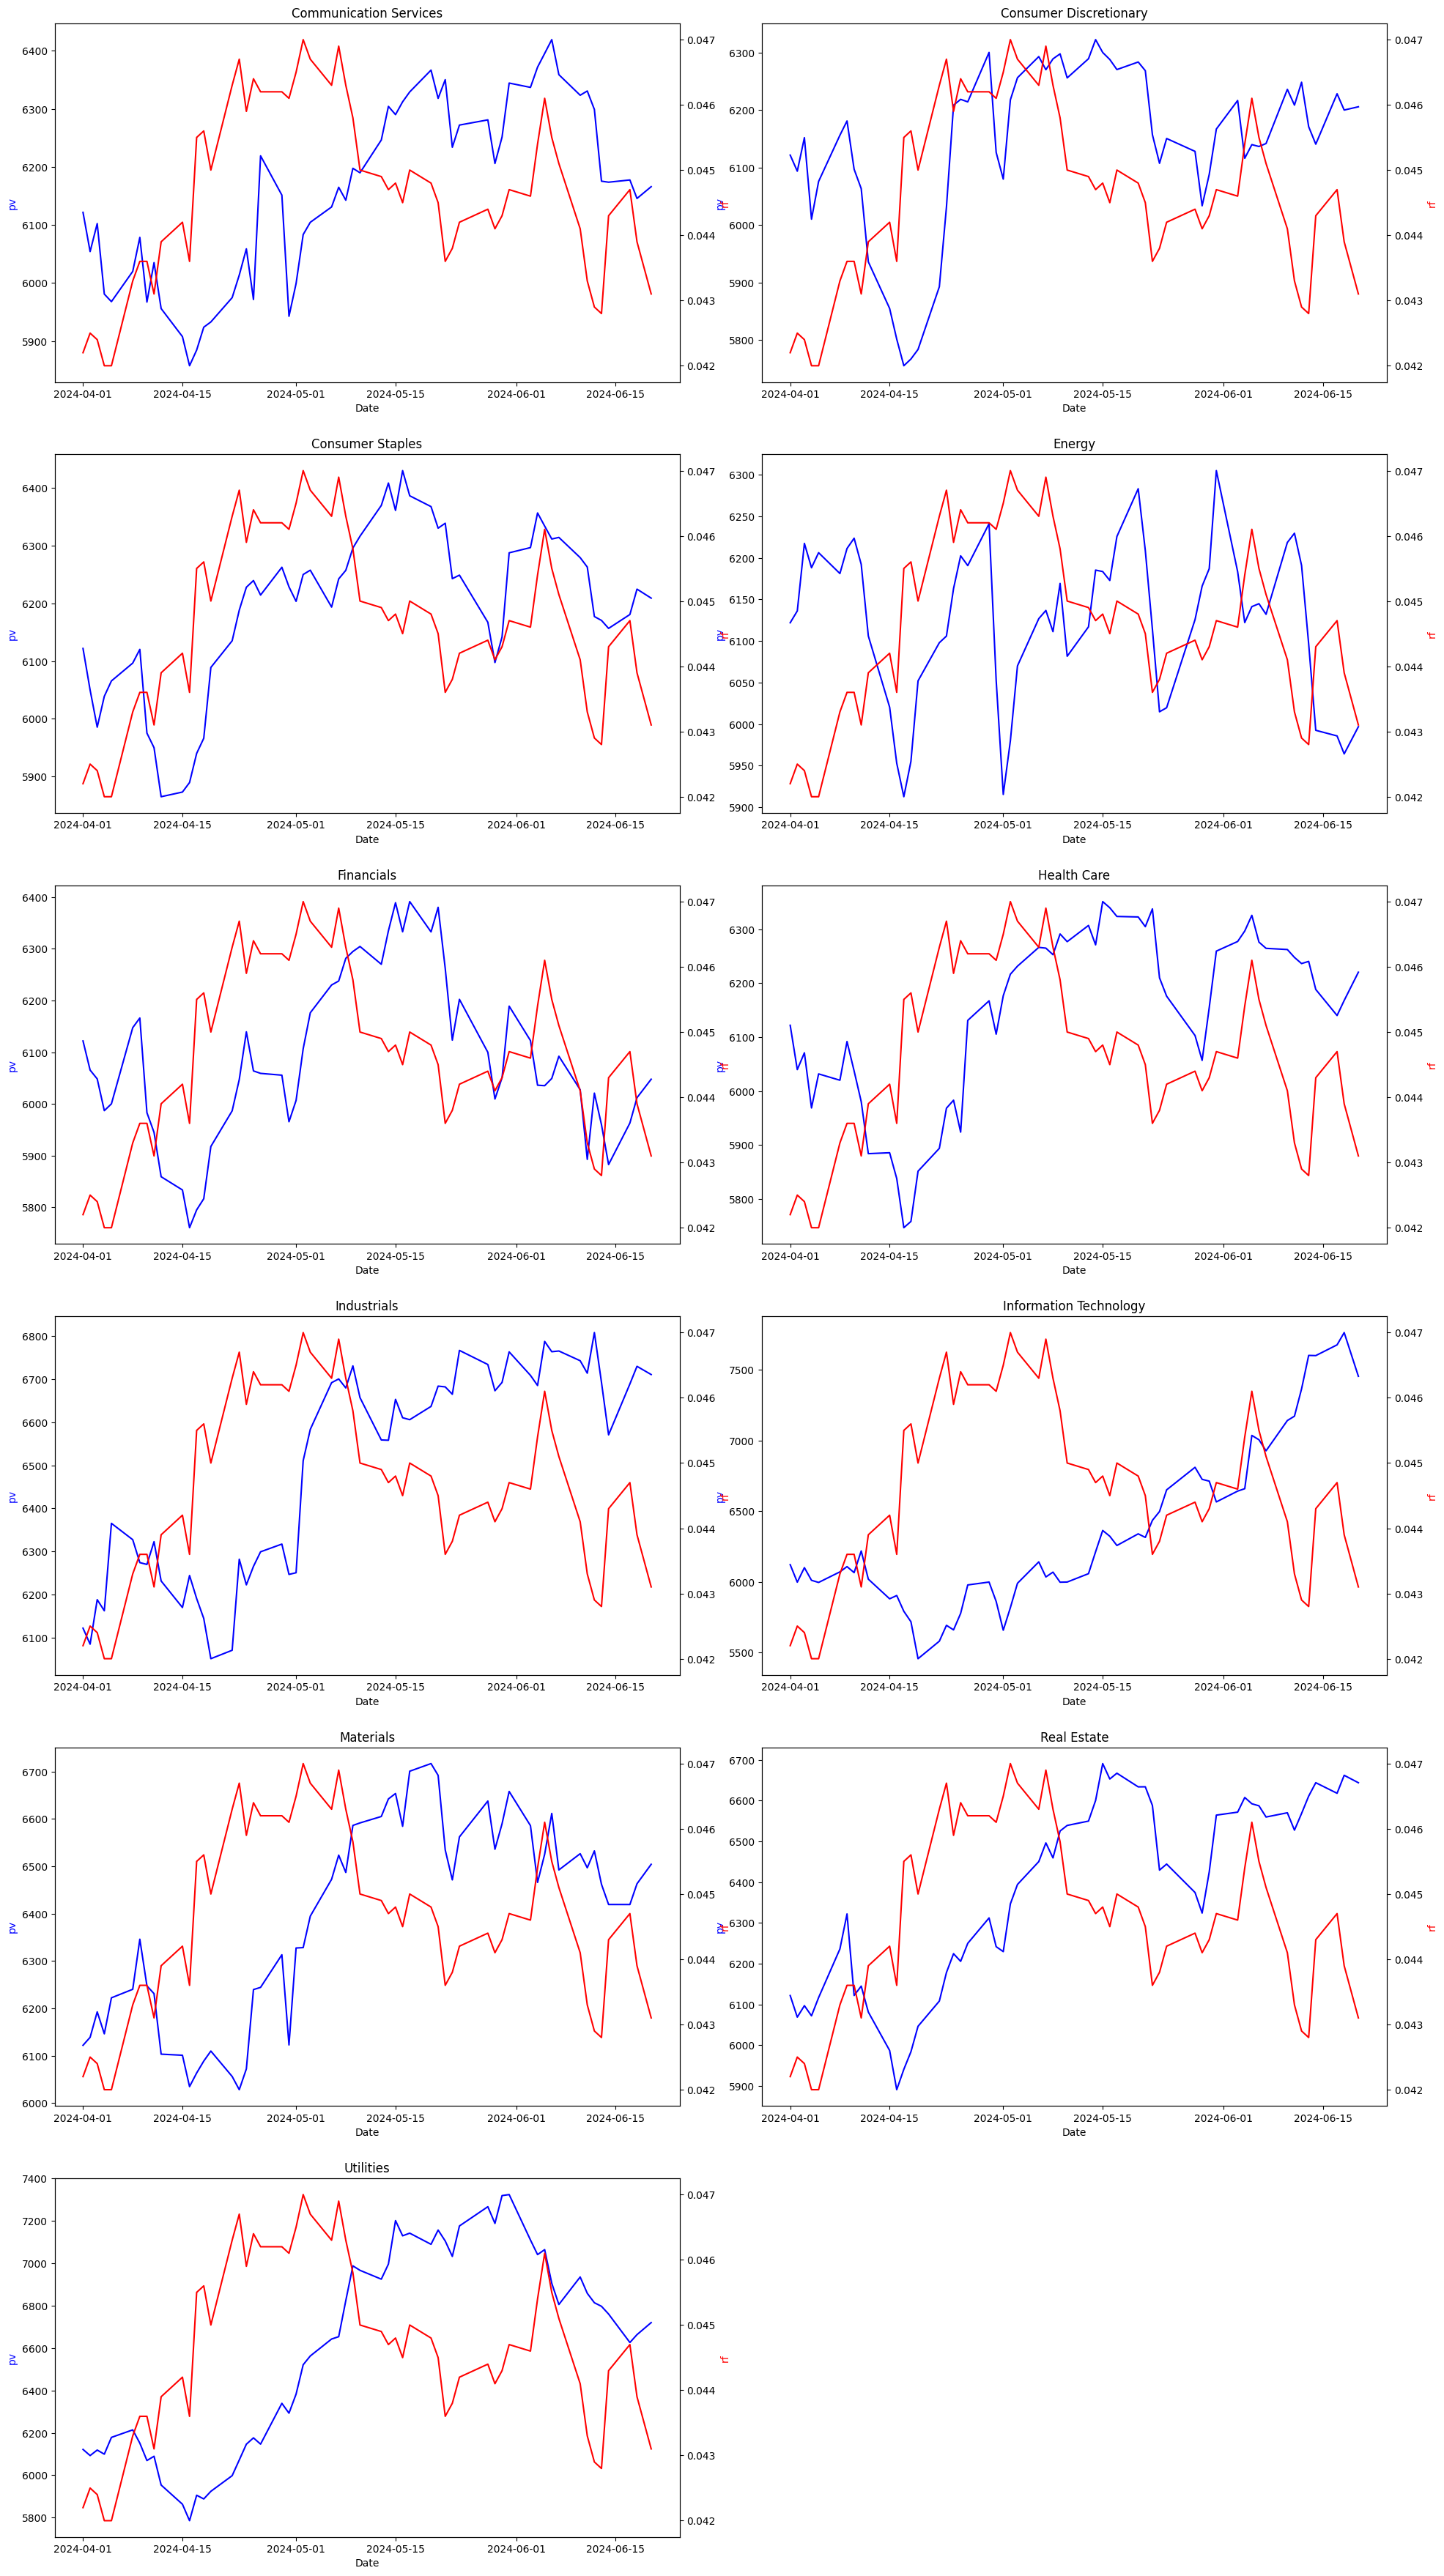

In [187]:
import matplotlib.pyplot as plt
import math

# Number of sectors
num_sectors = len(industry_visualization["GICS Sector"].unique())

# Determine the number of rows and columns for the grid
num_cols = 2
num_rows = math.ceil(num_sectors / num_cols)

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 6 * num_rows))
fig.tight_layout(pad=5.0)

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Loop through each unique sector
for i, sector in enumerate(industry_visualization["GICS Sector"].unique()):
    # Filter the data for the current sector and sort by date
    sector_viz = industry_visualization[industry_visualization["GICS Sector"] == sector].sort_values("date")
    
    # Select the current axis
    ax1 = axs[i]
    
    # Plot the 'pv' data on the primary y-axis
    ax1.plot(sector_viz["date"], sector_viz["pv"], color='b', label='pv')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('pv', color='b')
    
    # Create a secondary y-axis
    ax2 = ax1.twinx()
    
    # Plot the 'rf' data on the secondary y-axis
    ax2.plot(sector_viz["date"], sector_viz["rf"], color='r', label='rf')
    ax2.set_ylabel('rf', color='r')
    
    # Set the title
    ax1.set_title(sector)

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Show the plot
plt.show()


In [188]:
for state in states:
    try:
        state["stock_pv"] = sum([sum([state["positions"][i]["stocks"][j]["pv"] for j in range(number_of_stocks)]) for i in range(11)])
        state["option_pv"] = sum([sum([state["positions"][i]["options"][j]["pv"] for j in range(number_of_stocks)]) for i in range(11)])
        state["bond_pv"] = sum([sum([state["positions"][i]["bonds"][j]["pv"] for j in range(number_of_stocks)]) for i in range(11)])
        state["pv"] = state["cash"] + state["stock_pv"] + state["option_pv"] + state["bond_pv"]
    except Exception as e:
        print(str(e))
        continue

In [189]:
performance = pd.DataFrame(states).dropna()
performance["stock_return"] = (performance["stock_pv"] - performance["stock_pv"].iloc[0]) / performance["stock_pv"].iloc[0]
performance["bond_return"] = (performance["bond_pv"] - performance["bond_pv"].iloc[0]) / performance["bond_pv"].iloc[0]
performance["option_return"] = (performance["option_pv"] - performance["option_pv"].iloc[0]) / performance["option_pv"].iloc[0]
performance["return"] = (performance["pv"] - performance["pv"].iloc[0]) / performance["pv"].iloc[0]

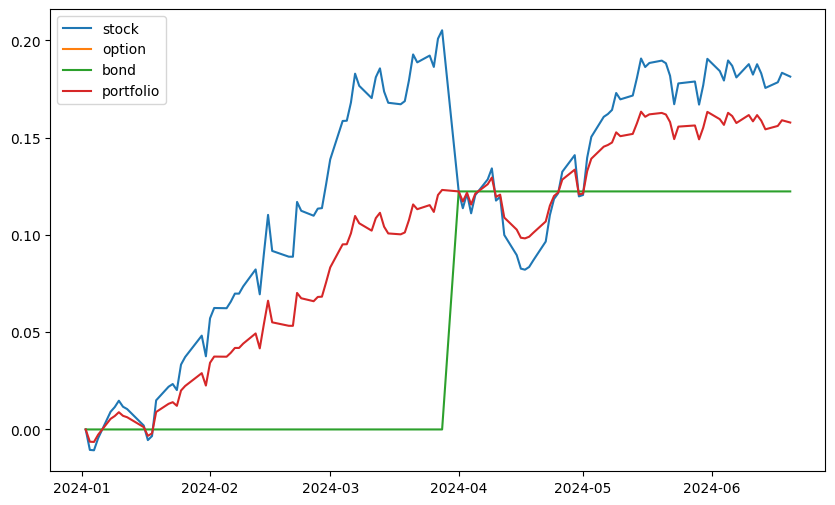

In [190]:
plt.figure(figsize=(10, 6))  
plt.plot(performance["date"].values,performance["stock_return"].values)
plt.plot(performance["date"].values,performance["option_return"].values)
plt.plot(performance["date"].values,performance["bond_return"].values)
plt.plot(performance["date"].values,performance["return"].values)
plt.legend(["stock","option","bond","portfolio"])

In [191]:
visualization = performance.merge(spy,on="date",how="left")
visualization = visualization.merge(market_yield[["date","rf"]],on="date",how="left")

In [192]:
visualization["return"] = (visualization["pv"] - visualization["pv"].iloc[0]) / visualization["pv"].iloc[0]
visualization["benchmark_return"] = (visualization["spy"] - visualization["spy"].iloc[0]) / visualization["spy"].iloc[0]
visualization["ir_return"] = (visualization["rf"] - visualization["rf"].iloc[0]) / visualization["rf"].iloc[0]

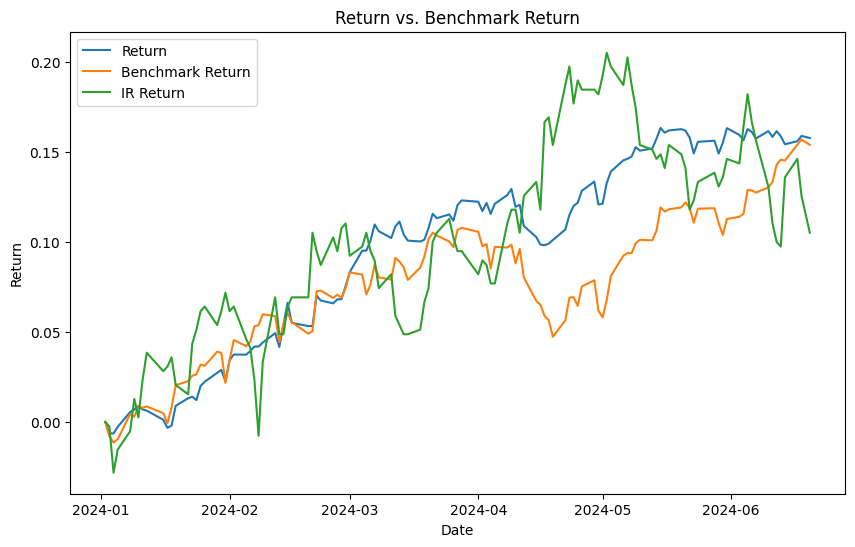

In [193]:
# Set the figure size
plt.figure(figsize=(10, 6))  # Adjust the width and height as needed

# Plot the data
plt.plot(visualization["date"].values, visualization["return"], label="Return")
plt.plot(visualization["date"].values, visualization["benchmark_return"], label="Benchmark Return")
plt.plot(visualization["date"].values, visualization["ir_return"], label="IR Return")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Return")
plt.title("Return vs. Benchmark Return")
plt.legend()

# Show the plot
plt.show()


In [194]:
pd.DataFrame(sum([[x["stocks"][i] for x in states[-1]["positions"]] for i in range(5)],[]))

,ticker,adjclose,quantity,type,buy_price,buy_date,pv,sell_date,date
0,TDG,1329.670000,1.008589,value,1213.940000,2024-04-01 00:00:00+00:00,1341.090761,2024-04-01 00:00:00+00:00,2024-06-20 00:00:00+00:00
1,VTRS,10.260000,103.711862,value,11.805465,2024-04-01 00:00:00+00:00,1064.083705,2024-04-01 00:00:00+00:00,2024-06-20 00:00:00+00:00
2,AVGO,1734.560000,0.906764,value,1350.260000,2024-04-01 00:00:00+00:00,1572.836022,2024-04-01 00:00:00+00:00,2024-06-20 00:00:00+00:00
3,VST,88.190000,17.159337,value,71.352799,2024-04-01 00:00:00+00:00,1513.281938,2024-04-01 00:00:00+00:00,2024-06-20 00:00:00+00:00
4,KEY,13.640000,80.161437,value,15.273762,2024-04-01 00:00:00+00:00,1093.402000,2024-04-01 00:00:00+00:00,2024-06-20 00:00:00+00:00
5,NEM,42.810000,33.816057,growth,36.206667,2024-04-01 00:00:00+00:00,1447.665406,2024-04-01 00:00:00+00:00,2024-06-20 00:00:00+00:00
6,F,11.940000,93.262418,value,13.128190,2024-04-01 00:00:00+00:00,1113.553270,2024-04-01 00:00:00+00:00,2024-06-20 00:00:00+00:00
7,DOC,19.380000,67.083571,growth,18.251365,2024-04-01 00:00:00+00:00,1300.079616,2024-04-01 00:00:00+00:00,2024-06-20 00:00:00+00:00
8,WBD,7.040000,139.290869,growth,8.790000,2024-04-01 00:00:00+00:00,980.607716,2024-04-01 00:00:00+00:00,2024-06-20 00:00:00+00:00
9,KDP,34.210000,39.204827,growth,31.230000,2024-04-01 00:00:00+00:00,1341.197120,2024-04-01 00:00:00+00:00,2024-06-20 00:00:00+00:00


In [195]:
(visualization["return"].iloc[-1] - visualization["benchmark_return"].iloc[-1]) / visualization["return"].std()

np.float64(0.06966417589404915)

In [196]:
visualization[["return","benchmark_return"]]

,return,benchmark_return
0,0.000000,0.000000
1,-0.006309,-0.008016
2,-0.006423,-0.011417
3,-0.002701,-0.009612
4,0.005445,0.004367
...,...,...
113,0.158729,0.145675
114,0.154246,0.145223
115,0.155993,0.154001
116,0.158912,0.156911


In [197]:
t = pd.DataFrame(trades).merge(sp500[["ticker","GICS Sector"]],on="ticker",how="left")
t["return"] = (t["adjclose"] - t["buy_price"]) / t["buy_price"]
t["color"] = ["red" if x == "value" else "green" for x in t["type"]]
t[["type","GICS Sector","return"]].groupby(["type","GICS Sector"]).mean().reset_index().sort_values("return")

,type,GICS Sector,return
3,growth,Utilities,-0.001101
13,value,Real Estate,0.026406
1,growth,Energy,0.089620
4,value,Communication Services,0.101759
8,value,Financials,0.106144
6,value,Consumer Staples,0.108723
12,value,Materials,0.109140
0,growth,Consumer Discretionary,0.121735
5,value,Consumer Discretionary,0.138836
9,value,Health Care,0.203237


In [198]:
t.sort_values("return",ascending=False).head(50)

,ticker,adjclose,quantity,type,buy_price,buy_date,pv,sell_date,GICS Sector,return,color
10,SMCI,1037.150000,3.821717,value,285.450000,2024-01-02 00:00:00+00:00,3963.693689,2024-04-01 00:00:00+00:00,Information Technology,2.633386,red
15,VST,71.352799,28.823500,value,37.847905,2024-01-02 00:00:00+00:00,2056.637398,2024-04-01 00:00:00+00:00,Utilities,0.885251,red
12,NVDA,90.352380,22.651721,value,48.160098,2024-01-02 00:00:00+00:00,2046.636878,2024-04-01 00:00:00+00:00,Information Technology,0.876084,red
41,META,490.863187,3.156769,value,345.577724,2024-01-02 00:00:00+00:00,1549.541754,2024-04-01 00:00:00+00:00,Communication Services,0.420413,red
14,WDC,70.850000,21.449255,value,50.860000,2024-01-02 00:00:00+00:00,1519.679691,2024-04-01 00:00:00+00:00,Information Technology,0.393040,red
2,GE,139.699151,10.872443,value,100.337067,2024-01-02 00:00:00+00:00,1518.871125,2024-04-01 00:00:00+00:00,Industrials,0.392299,red
51,MPC,203.437882,7.230416,value,150.877768,2024-01-02 00:00:00+00:00,1470.940597,2024-04-01 00:00:00+00:00,Energy,0.348362,red
43,NFLX,614.310000,2.328515,value,468.500000,2024-01-02 00:00:00+00:00,1430.429805,2024-04-01 00:00:00+00:00,Communication Services,0.311227,red
3,UBER,76.400000,18.686350,value,58.380000,2024-01-02 00:00:00+00:00,1427.637111,2024-04-01 00:00:00+00:00,Industrials,0.308667,red
9,DVA,137.840000,10.205904,value,106.890000,2024-01-02 00:00:00+00:00,1406.781823,2024-04-01 00:00:00+00:00,Health Care,0.289550,red
